# Model Comparison

In [1]:
# 1. Imports
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay
)

sns.set(style="whitegrid")

In [2]:
data = pd.read_csv("/kaggle/input/cleaned-data2/cleaned_data2.csv")

In [3]:
X = data.drop(columns=['Attack_Type'])
y = data['Attack_Type']

# Split first using raw labels
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Encode after split
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

In [4]:
import joblib

# Saving the models
rf_model = joblib.load('/kaggle/input/random-forest/scikitlearn/default/1/rf_pipeline_without_smote.pkl')
xgb_model = joblib.load('/kaggle/input/xgboost-model/other/default/1/xgb_pipeline.pkl')


In [5]:
# 4. Make predictions
# RF gives string labels → convert to encoded integers
rf_preds_str = rf_model.predict(X_test)
rf_preds = le.transform(rf_preds_str)

# XGBoost already outputs encoded labels
xgb_preds = xgb_model.predict(X_test)

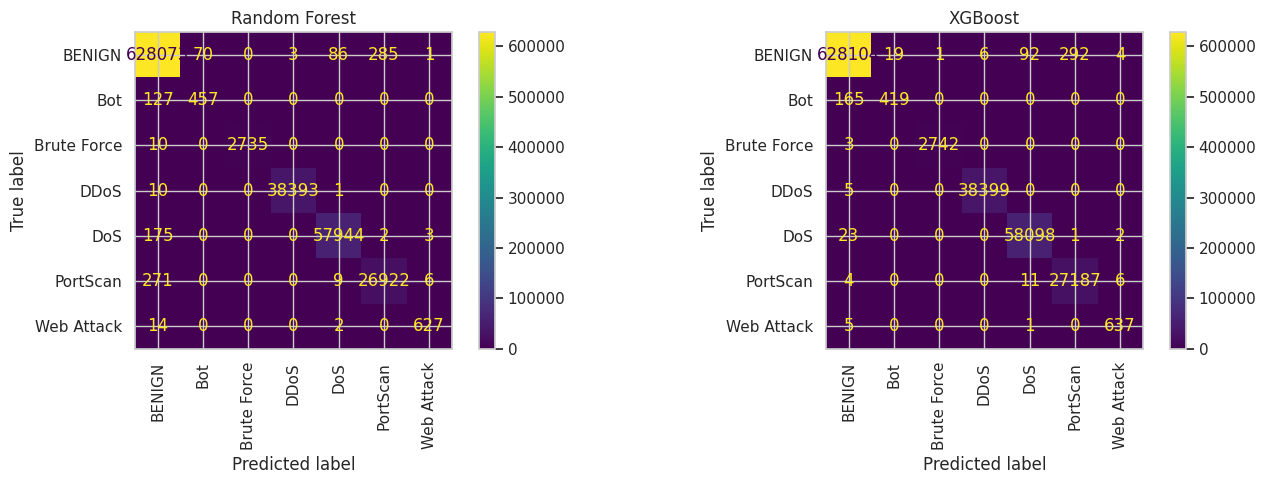

In [6]:
# 7. Confusion Matrices
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
disp_rf = ConfusionMatrixDisplay.from_predictions(y_test, rf_preds, display_labels=le.classes_, ax=axs[0])
axs[0].set_title("Random Forest")
axs[0].set_xticklabels(le.classes_, rotation=90)
axs[0].set_yticklabels(le.classes_)

# XGBoost
disp_xgb = ConfusionMatrixDisplay.from_predictions(y_test, xgb_preds, display_labels=le.classes_, ax=axs[1])
axs[1].set_title("XGBoost")
axs[1].set_xticklabels(le.classes_, rotation=90)
axs[1].set_yticklabels(le.classes_)

plt.tight_layout()
plt.show()


In [7]:
import numpy as np

benign_label = le.transform(["BENIGN"])[0]


def calculate_fp_fn(y_true, y_pred, benign_label="BENIGN"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # False Negatives: true is attack, predicted is BENIGN
    fn = np.sum((y_true != benign_label) & (y_pred == benign_label))

    # False Positives: true is BENIGN, predicted is attack
    fp = np.sum((y_true == benign_label) & (y_pred != benign_label))

    return fp, fn

# Random Forest
rf_fp, rf_fn = calculate_fp_fn(y_test, rf_preds, benign_label)
print(f"Random Forest - False Positives: {rf_fp}, False Negatives: {rf_fn}")

# XGBoost
xgb_fp, xgb_fn = calculate_fp_fn(y_test, xgb_preds, benign_label)
print(f"XGBoost - False Positives: {xgb_fp}, False Negatives: {xgb_fn}")


Random Forest - False Positives: 445, False Negatives: 607
XGBoost - False Positives: 414, False Negatives: 205


In [8]:
# 8. Classification Reports
print("\n--- RF Classification Report ---")
print(classification_report(y_test, rf_preds, target_names=le.classes_, digits=3))

print("\n--- XGB Classification Report ---")
print(classification_report(y_test, xgb_preds, target_names=le.classes_, digits=3))


--- RF Classification Report ---
              precision    recall  f1-score   support

      BENIGN      0.999     0.999     0.999    628518
         Bot      0.867     0.783     0.823       584
 Brute Force      1.000     0.996     0.998      2745
        DDoS      1.000     1.000     1.000     38404
         DoS      0.998     0.997     0.998     58124
    PortScan      0.989     0.989     0.989     27208
  Web Attack      0.984     0.975     0.980       643

    accuracy                          0.999    756226
   macro avg      0.977     0.963     0.970    756226
weighted avg      0.999     0.999     0.999    756226


--- XGB Classification Report ---
              precision    recall  f1-score   support

      BENIGN      1.000     0.999     1.000    628518
         Bot      0.957     0.717     0.820       584
 Brute Force      1.000     0.999     0.999      2745
        DDoS      1.000     1.000     1.000     38404
         DoS      0.998     1.000     0.999     58124
    PortS

# Comparison Conclusion


1. **Overall performance.**  
   Both the Random Forest and XGBoost models achieved strong results, with F1-scores of at least 0.98 across all classes except for the minority class “Bot.” Random Forest performed slightly better here, correctly identifying around 78% of bot attacks, while XGBoost correctly detected about 71%.

2. **False positives.**  
   The number of false positives—benign traffic incorrectly flagged as attacks—was low for both models: 445 for Random Forest and 414 for XGBoost. Given the dataset contains over 600,000 records, this accounts for only about 0.007% of the data, making it statistically insignificant.

3. **False negatives.**  
   XGBoost had a clear advantage in reducing false negatives. It mislabeled only 205 attacks as benign, compared to 607 for Random Forest. This shows that, in general, XGBoost was more effective at detecting threats.

4. **Misclassification between attack types.**  
   Both models were consistent in correctly identifying the type of attack. Cases where one attack was mistaken for another were very rare, indicating high reliability in classifying attacks once they were detected.

5. **Conclusion and recommendation.**  
   While both models performed well overall, XGBoost stands out due to its lower false negative rate. For deployment, this makes it the more suitable choice.

